In [12]:
%load_ext autoreload

%autoreload 2
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, roc_curve

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression

import warnings
import numpy as np
from collections import OrderedDict

from lob_data_utils import lob, db_result
from lob_data_utils.svm_calculation import lob_svm

sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
data_length = 10000
stock = '13003'

In [3]:
df, df_cv, df_test = lob.load_prepared_data(
    stock, data_dir='../queue_imbalance/data/prepared', cv=True, length=data_length)

In [4]:
df.head()

,Unnamed: 0,bid,ask,bid_price,ask_price,mid_price,sum_sell_ask,sum_buy_bid,mid_price_indicator,queue_imbalance
0,2013-09-02 09:00:00,"[(347.7, 1000.0), (353.7, 1000.0), (359.7, 100...","[(416.9, 1209.0), (417.0, 1067.0), (417.1, 146...",416.5,416.9,416.70,1209.0,1579.0,1.0,0.132712
1,2013-09-02 09:01:00,"[(347.7, 1000.0), (353.7, 1000.0), (359.7, 100...","[(416.9, 1713.0), (417.0, 1281.0), (417.1, 233...",416.6,416.9,416.75,1713.0,309.0,0.0,-0.694362
2,2013-09-02 09:02:00,"[(347.7, 1000.0), (353.7, 1000.0), (359.7, 100...","[(416.9, 1466.0), (417.0, 1281.0), (417.1, 233...",416.5,416.9,416.70,1466.0,1579.0,1.0,0.037110
3,2013-09-02 09:03:00,"[(347.7, 1000.0), (353.7, 1000.0), (359.7, 100...","[(417.2, 958.0), (417.3, 3089.0), (417.4, 3656...",416.8,417.2,417.00,958.0,2313.0,1.0,0.414246
4,2013-09-02 09:04:00,"[(347.7, 1000.0), (353.7, 1000.0), (359.7, 100...","[(417.3, 3937.0), (417.4, 2757.0), (417.5, 381...",416.9,417.3,417.10,3937.0,1260.0,1.0,-0.515105


## Data visualization

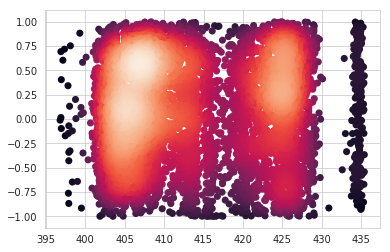

<Figure size 432x288 with 0 Axes>

In [6]:
lob.plot_density_imbalance_vs_mid(df, 0, len(df))

## Logistic

0.539378863078285

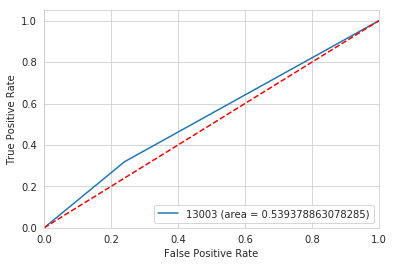

In [7]:
log_clf = lob.logistic_regression(df, 0, len(df))
pred = log_clf.predict(df_test['queue_imbalance'].values.reshape(-1, 1))
lob.plot_roc(df_test, log_clf, stock=int(stock), )

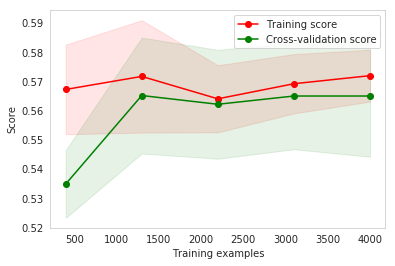

In [8]:
lob.plot_learning_curve(log_clf, df['queue_imbalance'].values.reshape(-1, 1), df['mid_price_indicator'])

## SVM

In [9]:
gammas = [0.0005, 0.005, 1, 5, 50, 500, 5000]
cs = [0.0005, 0.005, 1, 5.0, 50, 500, 1000]
coef0s = [0, 0.0005, 0.005, 1, 5, 50, 500, 5000]

try:
    df_svm_res = pd.read_csv('res_svm_{}.csv'.format(stock))
    print('Results read from file')
except FileNotFoundError:
    print('Results file does not exist yet')
    df_svm_res = pd.DataFrame(columns=['svm', 'c', 'gamma', 'coef0', 'roc_cv_score', 'roc_train_score'])
s = stock
svm_results = []
for c in cs:
    for g in gammas:
        for coef0 in coef0s:
            if np.any(df_svm_res[df_svm_res['c'] 
                             == c][df_svm_res['gamma'] == g][df_svm_res['coef0'] 
                                                             == coef0][df_svm_res['svm'] =='sigmoid']):
                continue
            
            svm = lob_svm.SVMSigmoid(s, df, c=c, coef0=coef0, gamma=g, data_length=data_length)
            cv_score = svm.predict(df_cv, 'cv', check=False)
            train_score = svm.predict(df, 'train', check=False)
            svm_results.append({'svm': 'sigmoid', 'c': c, 'coef0': coef0, 'gamma': g, 
                                'roc_cv_score': cv_score, 'roc_train_score': train_score})
        if np.any(df_svm_res[df_svm_res['c'] == c][df_svm_res['gamma'] == g][df_svm_res['svm'] =='rbf']):
            continue
        svm = lob_svm.SVMRbf(s, df, c=c, gamma=g, data_length=data_length)
        cv_score = svm.predict(df_cv, 'cv', check=False)
        train_score = svm.predict(df, 'train', check=False)
        svm_results.append({'svm': 'rbf', 'c': c, 'gamma': g, 
                            'roc_cv_score': cv_score, 'roc_train_score': train_score})
    if np.any(df_svm_res[df_svm_res['c'] == c][df_svm_res['svm'] =='linear']):
        continue
    svm = lob_svm.SVMLinear(s, df, c=c, data_length=data_length)
    cv_score = svm.predict(df_cv, 'cv', check=False)
    train_score = svm.predict(df, 'train', check=False)
    svm_results.append({'svm': 'linear', 'c': c, 'roc_cv_score': cv_score, 'roc_train_score': train_score})
    pd.DataFrame(svm_results).to_csv('new_svm_{}.csv'.format(stock))
for svm_result in svm_results:
    df_svm_res = df_svm_res.append(svm_result, ignore_index=True)
df_svm_res.sort_values(by='roc_cv_score', ascending=False)
df_svm_res.head()

Results read from file


,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1,Unnamed: 0.1.1.1.1,Unnamed: 0.1.1.1.1.1,c,coef0,gamma,roc_cv_score,roc_train_score,svm
0,0,0,0,0,0,0.0,1.0000,1.0000,1.0000,0.515721,0.516801,sigmoid
1,1,1,1,1,1,1.0,1.0000,NaN,1.0000,0.561307,0.558870,rbf
2,2,2,2,2,2,2.0,1.0000,NaN,NaN,0.564741,0.563737,linear
3,3,3,3,3,3,NaN,0.0005,0.0000,0.0005,0.500000,0.500000,sigmoid
4,4,4,4,4,4,NaN,0.0005,0.0005,0.0005,0.500000,0.500000,sigmoid


In [ ]:
df_svm_res.to_csv('res_svm_{}.csv'.format(stock))
df_svm_res.sort_values(by='roc_cv_score').head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1,Unnamed: 0.1.1.1.1,Unnamed: 0.1.1.1.1.1,c,coef0,gamma,roc_cv_score,roc_train_score,svm
443,443,443,443,443,443,NaN,1000.000,50.0000,5000.0000,0.465116,0.466641,sigmoid
251,251,251,251,251,251,NaN,5.000,50.0000,5000.0000,0.465116,0.466324,sigmoid
379,379,379,379,379,379,NaN,500.000,50.0000,5000.0000,0.465116,0.466641,sigmoid
315,315,315,315,315,315,NaN,50.000,50.0000,5000.0000,0.465116,0.466482,sigmoid
188,188,188,188,188,188,NaN,1.000,50.0000,5000.0000,0.466116,0.466658,sigmoid
106,106,106,106,106,106,NaN,0.005,1.0000,50.0000,0.494997,0.495899,sigmoid
160,160,160,160,160,160,NaN,1.000,5.0000,5.0000,0.498855,0.487268,sigmoid
307,307,307,307,307,307,NaN,50.000,500.0000,500.0000,0.499144,0.498719,sigmoid
371,371,371,371,371,371,NaN,500.000,500.0000,500.0000,0.499168,0.499106,sigmoid
435,435,435,435,435,435,NaN,1000.000,500.0000,500.0000,0.499168,0.499300,sigmoid


## GDF

In [ ]:
K = 50

def gdf_svm_classification(df, Kn, C=1000, gamma=1):
    clf = SVC(kernel='rbf', C=C, gamma=gamma)
    gdf_columns = ['gdf_' + str(i) for i in range(0, Kn)]
    X = df.loc[:, gdf_columns]
    y = df['mid_price_indicator'].values.reshape(-1, 1)
    y[0] = 0
    clf.fit(X, y)
    return clf

length = data_length
rr = [0.01, 0.05, 0.1, 0.5, 1]
ss = [0.01, 0.05, 0.1, 0.5, 1]
results = []
Kn = 10

try:
    df_gdf_res = pd.read_csv('res_gdf_svm_{}_{}.csv'.format(stock, Kn))
    print('Results read from file')
except FileNotFoundError:
    print('Results file does not exist yet')
    df_gdf_res = pd.DataFrame(columns=['svm', 'c', 'gamma', 'roc_cv_score', 'roc_train_score',
                                          'K', 'Kn', 'r', 's'])


for r in rr:
    for s in ss:

        filename = 'gdf_{}_len{}_r{}_s{}_K{}'.format(stock, length, r, s, K)
        dfs, dfs_cv, dfs_test = lob.load_prepared_data(
            filename, data_dir='../gaussian_filter/data_gdf/', cv=True, length=length)
        gdf_columns = ['gdf_' + str(i) for i in range(0, Kn)]

        for C in [1, 10, 100, 1000, 10000]:
            for gamma in [1, 10, 100, 1000, 10000]:
                res = {}
                res['c'] = C
                res['gamma'] = gamma
                res['r'] = r
                res['s'] = s
                res['stock'] = stock
                res['K'] = K
                res['svm'] = 'rbf'
                res['Kn'] = Kn
                if np.any(df_gdf_res[df_gdf_res['c'] 
                             == C][df_gdf_res['gamma'] 
                                   == gamma][df_gdf_res['r'] 
                                             == r][df_gdf_res['s'] 
                                                   == s][df_gdf_res['K'] 
                                                         == K][df_gdf_res['svm'] == 'rbf']):
                    continue
                

                clf = gdf_svm_classification(dfs, Kn, C=C, gamma=gamma)
                predictions = clf.predict(dfs.loc[:, gdf_columns])
                try:
                    roc_train = roc_auc_score(predictions, dfs['mid_price_indicator'])
                    res['roc_train_score'] = roc_train
                except Exception as e:
                    print(e, r, s, C, gamma)
                predictions = clf.predict(dfs_cv.loc[:, gdf_columns])
                try:
                    roc_cv = roc_auc_score(predictions, dfs_cv['mid_price_indicator'])
                    res['roc_cv_score'] = roc_cv
                except Exception as e:
                    print(e, r, s, C, gamma)
                results.append(res)
                pd.DataFrame(results).to_csv('new_res_gdf_svm_{}_{}.csv'.format(stock, Kn))
for result in results:
    df_gdf_res = df_gdf_res.append(result, ignore_index=True)


Results file does not exist yet
Only one class present in y_true. ROC AUC score is not defined in that case. 0.01 0.01 1 1
Only one class present in y_true. ROC AUC score is not defined in that case. 0.01 0.01 1 1
Only one class present in y_true. ROC AUC score is not defined in that case. 0.01 0.01 1 10
Only one class present in y_true. ROC AUC score is not defined in that case. 0.01 0.01 1 10
Only one class present in y_true. ROC AUC score is not defined in that case. 0.01 0.01 1 100
Only one class present in y_true. ROC AUC score is not defined in that case. 0.01 0.01 1 100
Only one class present in y_true. ROC AUC score is not defined in that case. 0.01 0.01 10 1
Only one class present in y_true. ROC AUC score is not defined in that case. 0.01 0.01 10 1
Only one class present in y_true. ROC AUC score is not defined in that case. 0.01 0.01 10 10
Only one class present in y_true. ROC AUC score is not defined in that case. 0.01 0.01 10 10
Only one class present in y_true. ROC AUC scor

Only one class present in y_true. ROC AUC score is not defined in that case. 0.01 1 1 100
Only one class present in y_true. ROC AUC score is not defined in that case. 0.01 1 1 1000
Only one class present in y_true. ROC AUC score is not defined in that case. 0.01 1 1 1000
Only one class present in y_true. ROC AUC score is not defined in that case. 0.01 1 10 1
Only one class present in y_true. ROC AUC score is not defined in that case. 0.01 1 10 1
Only one class present in y_true. ROC AUC score is not defined in that case. 0.01 1 10 10
Only one class present in y_true. ROC AUC score is not defined in that case. 0.01 1 10 10
Only one class present in y_true. ROC AUC score is not defined in that case. 0.01 1 10 100
Only one class present in y_true. ROC AUC score is not defined in that case. 0.01 1 10 100
Only one class present in y_true. ROC AUC score is not defined in that case. 0.01 1 10 1000
Only one class present in y_true. ROC AUC score is not defined in that case. 0.01 1 10 1000
Only

Only one class present in y_true. ROC AUC score is not defined in that case. 0.05 0.5 1000 10
Only one class present in y_true. ROC AUC score is not defined in that case. 0.05 0.5 10000 1
Only one class present in y_true. ROC AUC score is not defined in that case. 0.05 0.5 10000 1
Only one class present in y_true. ROC AUC score is not defined in that case. 0.05 1 1 1
Only one class present in y_true. ROC AUC score is not defined in that case. 0.05 1 1 1
Only one class present in y_true. ROC AUC score is not defined in that case. 0.05 1 1 10
Only one class present in y_true. ROC AUC score is not defined in that case. 0.05 1 1 10
Only one class present in y_true. ROC AUC score is not defined in that case. 0.05 1 10 1
Only one class present in y_true. ROC AUC score is not defined in that case. 0.05 1 10 1
Only one class present in y_true. ROC AUC score is not defined in that case. 0.05 1 10 10
Only one class present in y_true. ROC AUC score is not defined in that case. 0.05 1 10 10
Only o

Only one class present in y_true. ROC AUC score is not defined in that case. 0.5 0.01 10000 1
Only one class present in y_true. ROC AUC score is not defined in that case. 0.5 0.05 1 1
Only one class present in y_true. ROC AUC score is not defined in that case. 0.5 0.05 1 1
Only one class present in y_true. ROC AUC score is not defined in that case. 0.5 0.05 1 10
Only one class present in y_true. ROC AUC score is not defined in that case. 0.5 0.05 1 10
Only one class present in y_true. ROC AUC score is not defined in that case. 0.5 0.05 1 100
Only one class present in y_true. ROC AUC score is not defined in that case. 0.5 0.05 10 1
Only one class present in y_true. ROC AUC score is not defined in that case. 0.5 0.05 10 1
Only one class present in y_true. ROC AUC score is not defined in that case. 0.5 0.05 10 10
Only one class present in y_true. ROC AUC score is not defined in that case. 0.5 0.05 10 10
Only one class present in y_true. ROC AUC score is not defined in that case. 0.5 0.05 

In [ ]:
df_gdf_res.to_csv('res_gdf_svm_{}_{}.csv'.format(stock, Kn))

In [ ]:
a = df_gdf_res[df_gdf_res['r'] == 0.1].sort_values(by='roc_cv_score', ascending=False).sort_values(by='s')
a[['s', 'roc_train_score', 'roc_cv_score']].plot(kind='bar', figsize=(16,16))

## GDF with logistic reg

In [ ]:
K = 50

def gdf_log_classification(df, Kn, C=1000):
    gdf_columns = ['gdf_' + str(i) for i in range(0, Kn)]
    clf = LogisticRegression(C=C)
    X = df.loc[:, gdf_columns]
    y = df['mid_price_indicator'].values.reshape(-1, 1)
    y[0] = 0
    clf.fit(X, y)
    return clf

length = data_length
rr = [0.01, 0.05, 0.1, 0.5, 1]
ss = [0.01, 0.05, 0.1, 0.5, 1]
results = []
Kn = 4

try:
    df_gdf_log_res = pd.read_csv('res_gdf_log_{}_{}.csv'.format(stock, Kn))
    print('Results read from file')
except FileNotFoundError:
    print('Results file does not exist yet')
    df_gdf_log_res = pd.DataFrame(columns=['c', 'roc_cv_score', 'roc_train_score', 'K', 'Kn', 'r', 's'])

for r in rr:
    for s in ss:

        filename = 'gdf_{}_len{}_r{}_s{}_K{}'.format(stock, length, r, s, K)
        dfs, dfs_cv, dfs_test = lob.load_prepared_data(
            filename, data_dir='../gaussian_filter/data_gdf/', cv=True, length=length)
        gdf_columns = ['gdf_' + str(i) for i in range(0, Kn)]

        for C in [1, 10, 100, 1000, 10000]:
            res = {}
            res['c'] = C
            res['r'] = r
            res['s'] = s
            res['stock'] = stock
            res['K'] = K
            res['Kn'] = Kn
            if np.any(df_gdf_log_res[df_gdf_log_res['c'] 
                         == C][df_gdf_log_res['r'] == r][df_gdf_log_res['s'] == s][df_gdf_log_res['K'] == K]):
                continue

            clf = gdf_log_classification(dfs, Kn, C=C)
            predictions = clf.predict(dfs.loc[:, gdf_columns])
            try:
                roc_train = roc_auc_score(predictions, dfs['mid_price_indicator'])
                res['roc_train_score'] = roc_train
            except Exception as e:
                print(e, r, s, C, gamma)
            predictions = clf.predict(dfs_cv.loc[:, gdf_columns])
            try:
                roc_cv = roc_auc_score(predictions, dfs_cv['mid_price_indicator'])
                res['roc_cv_score'] = roc_cv
            except Exception as e:
                print(e, r, s, C, gamma)
            results.append(res)
            pd.DataFrame(results).to_csv('new_res_gdf_log_{}_{}.csv'.format(stock, Kn))
for result in results:
    df_gdf_log_res = df_gdf_log_res.append(result, ignore_index=True)


In [ ]:
df_gdf_log_res.to_csv('res_gdf_log_{}_{}.csv'.format(stock, Kn))

In [ ]:
df_gdf_log_res.sort_values(by='roc_cv_score', ascending=False).head(5)

In [ ]:
df_gdf_res.sort_values(by='roc_cv_score', ascending=False).head(5)

## Results on test

In [ ]:
best_gdf_res = df_gdf_res.sort_values(by='roc_cv_score', ascending=False).iloc[0]
best_gdf_log_res = df_gdf_log_res.sort_values(by='roc_cv_score', ascending=False).iloc[0]
best_svm_sig_res = df_svm_res[df_svm_res['svm'] == 'sigmoid'].sort_values(
    by='roc_cv_score', ascending=False).iloc[0]
best_svm_rbf_res = df_svm_res[df_svm_res['svm'] == 'rbf'].sort_values(
    by='roc_cv_score', ascending=False).iloc[0]          
best_svm_lin_res = df_svm_res[df_svm_res['svm'] == 'linear'].sort_values(
    by='roc_cv_score', ascending=False).iloc[0]
res_dict = OrderedDict({
    'gdf_svm': best_gdf_res,
    'gdf_log': best_gdf_log_res,
    'svm_rbf': best_svm_rbf_res,
    'svm_lin': best_svm_lin_res,
    'svm_sig': best_svm_sig_res,
})

In [ ]:
list(res_dict.values())[0]

In [ ]:
filename = 'gdf_{}_len{}_r{}_s{}_K{}'.format(stock, length, best_gdf_res['r'], best_gdf_res['s'], 
                                             int(best_gdf_res['K']))
dfs, dfs_cv, dfs_test = lob.load_prepared_data(
    filename, data_dir='../gaussian_filter/data_gdf/', cv=True, length=length)
svm_gdf_clf = gdf_svm_classification(dfs, K, C=best_gdf_res['c'], gamma=best_gdf_res['gamma'])
gdf_columns = ['gdf_' + str(i) for i in range(0, K)]
pred_test = svm_gdf_clf.predict(dfs_test.loc[:, gdf_columns])
roc_test = roc_auc_score(pred_test, dfs_test['mid_price_indicator'])
best_gdf_res['roc_test_score'] = roc_test
roc_test

In [ ]:
filename = 'gdf_{}_len{}_r{}_s{}_K{}'.format(
    stock, length, best_gdf_log_res['r'], best_gdf_log_res['s'], int(best_gdf_log_res['K']))
dfs, dfs_cv, dfs_test = lob.load_prepared_data(
    filename, data_dir='../gaussian_filter/data_gdf/', cv=True, length=length)
svm_gdf_clf = gdf_log_classification(dfs, K, C=best_gdf_res['c'])
gdf_columns = ['gdf_' + str(i) for i in range(0, K)]
pred_test = svm_gdf_clf.predict(dfs_test.loc[:, gdf_columns])
roc_test = roc_auc_score(pred_test, dfs_test['mid_price_indicator'])
best_gdf_log_res['roc_test_score'] = roc_test
roc_test

In [ ]:
df, df_cv, df_test = lob.load_prepared_data(
    stock, data_dir='../queue_imbalance/data/prepared', cv=True, length=data_length)

svm = lob_svm.SVMRbf(stock, df, c=best_svm_rbf_res['c'], gamma=best_svm_rbf_res['gamma'], data_length=data_length)
roc_test = svm.predict(df_test, 'test', check=False)
best_svm_rbf_res['roc_test_score'] = roc_test

svm = lob_svm.SVMSigmoid(stock, df, c=best_svm_sig_res['c'], 
                         gamma=best_svm_sig_res['gamma'], coef0=best_svm_sig_res['coef0'])
roc_test = svm.predict(df_test, 'test', check=False)
best_svm_sig_res['roc_test_score'] = roc_test

svm = lob_svm.SVMLinear(stock, df, c=best_svm_lin_res['c'])
roc_test = svm.predict(df_test, 'test', check=False)
best_svm_lin_res['roc_test_score'] = roc_test

In [ ]:
res = []
for k, v in res_dict.items():
    dd = v.to_dict()
    dd['type'] = k
    res.append(dd)
df_res = pd.DataFrame(res)

df_res[['roc_train_score', 'roc_cv_score', 'roc_test_score']].plot(kind='bar', figsize=(8, 8))
d = plt.xticks(list(range(len(res_dict.keys()))), list(res_dict.keys()))
plt.legend(loc='upper right')

In [ ]:
print(res_dict['gdf_svm'])